## Utilities

In [90]:
"""
This script provides utility functions for formatted printing of NumPy matrices and saving matrices to CSV files.
"""


# system imports
import os

# third party imports
import numpy as np


def printFormatted(matrix, decimals=4):
    """
    Prints the matrix with formatted elements aligned in columns for improved readability.

    Parameters:
    ----------
    matrix : numpy array
        The matrix to be printed.
    decimals : int, optional (default=4)
        The number of decimal places for formatting the elements.

    Returns:
    -------
    None
        This function does not return any value; it prints the formatted matrix directly to the console.

    Notes:
    -----
    - The function aligns columns based on the maximum width needed for the formatted elements, ensuring the matrix is displayed neatly.
    - This function is useful for visual inspection of numerical matrices, especially those with varying magnitudes.
    
    Example:
    --------
    >>> import numpy as np
    >>> matrix = np.array([[1.234567, 123.456789], [0.0001234, 1.2345]])
    >>> print('Classic print:')
    >>> print(matrix)
    Classic print:
    [[1.2345670e+00 1.2345679e+02]
     [1.2340000e-04 1.2345000e+00]]
     
    >>> print('\nFormatted print:')
    >>> printFormatted(matrix, decimals=4)
         1.2346  123.4568
         0.0001    1.2345
    
    """

    # Determine the maximum width needed to keep alignment
    max_width = max(len(f'{value:.{decimals}f}') for row in matrix for value in row)

    # Create a formatted string for each element in the matrix, ensuring alignment
    formatted_matrix = '\n'.join([' '.join([f'{value:>{max_width}.{decimals}f}' for value in row]) for row in matrix])

    # Print the formatted matrix
    print(formatted_matrix)


def py_test_csv(array):
    """
    Save a numpy array as a CSV file in ./debugCsvPy/py_test.csv

    Parameters:
    array (numpy.ndarray): The input array to be saved as a CSV file.
    Returns:
    None
    """
    
    output_dir = 'debugCsvPy'  # Directory where CSV files will be stored
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    py_dict_path = os.path.join(output_dir, 'py_test.csv')
    np.savetxt(py_dict_path, array, delimiter=',', fmt='%.6f')



## Measurement matrix

In [91]:
import numpy as np

def generate_DBBD_matrix(M, N):
    """
    Generates a deterministic Diagonally Blocked Block Diagonal (DBBD) matrix.

    A DBBD matrix is a type of block diagonal matrix where each block is a square diagonal matrix.

    Parameters
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix. Should be a multiple of M.

    Returns
    -------
    A : numpy.ndarray
        The generated DBBD matrix of shape (M, N).

    Raises
    ------
    ValueError
        If `N` is not a multiple of `M`.

    Example
    -------
    >>> generate_DBDD_matrix(3, 9)
    array([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 1., 1., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 1., 1.]])
    """


    if N % M != 0:
        raise ValueError("N should be a multiple of M.")
    
    Phi = np.zeros((M, N))
    m = N // M
    
    for i in range(M):
        Phi[i, i*m:(i+1)*m] = 1

    return Phi


def generate_random_matrix(M, N, matrix_type='gaussian'):
    """
    Generates a random matrix based on the specified type.

    Parameters
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix.
    matrix_type : str, optional (default='gaussian')
        The type of random matrix to generate. Options are:
        - 'gaussian': A matrix with entries drawn from a normal distribution scaled by 1/M.
        - 'scaled_binary': A matrix with binary entries (±0.5), scaled by 1/sqrt(M).
        - 'unscaled_binary': A matrix with binary entries (±1), with no scaling.

    Returns
    -------
    A : numpy.ndarray
        The generated random matrix of shape (M, N).

    Raises
    ------
    ValueError
        If `matrix_type` is not one of the supported types.

    Example
    -------
    >>> generate_random_matrix(2, 3, matrix_type='gaussian')
    array([[ 0.01, -0.02,  0.03],
           [-0.04,  0.05, -0.06]])

    >>> generate_random_matrix(2, 3, matrix_type='scaled_binary')
    array([[-0.5,  0. , -0.5],
           [ 0.5, -0.5,  0. ]])
    
    >>> generate_random_matrix(2, 3, matrix_type='unscaled_binary')
    array([[ 1., -1.,  1.],
           [-1.,  1., -1.]])
    """
    if matrix_type == 'gaussian':
        A = ((1/M)**2) * np.random.randn(M, N)

    elif matrix_type == 'scaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) - 0.5
        A = (1/np.sqrt(M)) * A

    elif matrix_type == 'unscaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) * 2 - 1

    else:
        raise ValueError("Unsupported matrix type. Choose either 'gaussian', 'scaled_binary', or 'unscaled_binary'.")

    return A

## Dictionaries

### Fixed Dictionary

In [92]:
"""
This script provides utility functions for generating a Discrete Cosine Transform (DCT) 
orthonormal basis matrix and for testing various properties of matrices such as independence 
of columns, normalization, and coherence.
"""

import numpy as np
import scipy.fftpack as fftpack
import pywt

def dct_dictionary(N):
    """
    Generates a Discrete Cosine Transform (DCT) orthonormal basis matrix.

    The DCT basis is commonly used in signal processing and data compression. 
    It transforms a signal into a sum of cosine functions oscillating at different frequencies. 
    The resulting matrix can be used for orthogonal transformations of signals.
    
    DCT basis is sparifying.
    

    Parameters
    ----------
    N : int
        The size of the dictionary (i.e., the length of the signal).

    Returns
    -------
    dict_matrix : numpy.ndarray
        The generated DCT dictionary matrix of shape (N, N), where each column represents 
        a DCT basis vector.

    Example
    -------
    >>> generate_dct_dictionary(4)
    array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ],
           [ 0.65328148,  0.27059805, -0.27059805, -0.65328148],
           [ 0.5       , -0.5       , -0.5       ,  0.5       ],
           [ 0.27059805, -0.65328148,  0.65328148, -0.27059805]])
    """
    
    # Generate a DCT basis dictionary
    dict_matrix = fftpack.dct(np.eye(N), norm='ortho')    
    return dict_matrix



### Adaptive dictionary learning

In [93]:
"""
Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.
"""

import numpy as np


def OMP(dictio, sig, max_coeff):
    """
    Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.

    This function implements the OMP algorithm, which is used to find the sparse
    representation of a signal over a given dictionary.
    
    Parameters
    ----------
    dictio : numpy.ndarray
        The dictionary to use for sparse coding. It should be a matrix of size (n x K), 
        where n is the signal dimension and K is the number of atoms in the dictionary.
        (its columns MUST be normalized).
    
    sig : numpy.ndarray
        The signals to represent using the dictionary. 
        It should be a matrix of size (n x N), where N is the number of signals.
    
    max_coeff : int
        The maximum number of coefficients to use for representing each signal.
    
    Returns
    -------
    s : numpy.ndarray
        The sparse representation of the signals over the dictionary.
        It should be a matrix of size (K x N).
    """

    [n, p] = sig.shape
    [_, key] = dictio.shape
    s = np.zeros((key, p))
    for k in range(p):
        x = sig[:, k]
        residual = x.copy()
        indx = np.array([], dtype=int)
        current_atoms = np.empty((n, 0))
        norm_x = np.linalg.norm(x)
        for j in range(max_coeff):
            proj = dictio.T @ residual
            pos = np.argmax(np.abs(proj))
            indx = np.append(indx, pos)
            # Update selected atoms matrix
            current_atoms = np.column_stack((current_atoms, dictio[:, pos]))
            # Solve least squares problem using QR decomposition for stability
            q, r = np.linalg.qr(current_atoms)
            a = np.linalg.solve(r, q.T @ x)
            residual = x - current_atoms @ a
            # Break if norm of residual is suff small (relative to original signal)
            if np.linalg.norm(residual) < 1e-6 * norm_x:
                break
        temp = np.zeros((key,))
        temp[indx] = a
        s[:, k] = temp

    return s


In [94]:
"""
MOD (Method of Optimal Directions) algorithm for dictionary learning with improved numerical stability.
"""

# system imports
import os

# third party imports
import numpy as np
import scipy.sparse as sp
from scipy.linalg import solve



def I_findDistanceBetweenDictionaries(original, new):
    """
    Calculates the distance between two dictionaries.

    Parameters:
    ----------
    original : numpy.ndarray
        The original dictionary.

    new : numpy.ndarray
        The new dictionary.

    Returns:
    -------
    catchCounter : int
        The number of elements that satisfy the condition errorOfElement < 0.01.
    totalDistances : float
        The sum of all errorOfElement values.
    
    
    """

    # first: all the columns in the original start with positive values
    catchCounter = 0
    totalDistances = 0

    for i in range(new.shape[1]):
        new[:,i] = np.sign(new[0,i]) * new[:,i]

    for i in range(original.shape[1]):
        d = np.sign(original[0,i]) * original[:,i]
        distances = np.sum(new - np.tile(d, (1, new.shape[1])), axis=0)
        index = np.argmin(distances)
        errorOfElement = 1 - np.abs(new[:,index].T @ d)
        totalDistances += errorOfElement
        catchCounter += errorOfElement < 0.01

    ratio = catchCounter / original.shape[1]
    return ratio, totalDistances





def MOD(data, parameters):
    """
    Method of Optimal Directions (MOD) algorithm for dictionary learning .

    The MOD algorithm is a method for learning a dictionary for sparse representation of signals.
    It iteratively updates the dictionary to best represent the input data with sparse coefficients
    using the Orthogonal Matching Pursuit (OMP) algorithm.

    Parameters
    ----------
    data : numpy.ndarray
        An (n x N) matrix containing N signals, each of dimension n.
    
    parameters : dict
        A dictionary containing the parameters for the MOD algorithm:
            - K : int
                The number of dictionary elements (columns) to train.
            
            - num_iterations : int
                The number of iterations to perform for dictionary learning.
            
            - initialization_method : str
                Method to initialize the dictionary. Options are:
                * 'DataElements' - Initializes the dictionary using the first K data signals.
                * 'GivenMatrix' - Initializes the dictionary using a provided matrix 
                  (requires 'initial_dictionary' key).

            - initial_dictionary : numpy.ndarray, optional
                The initial dictionary matrix to use if 'initialization_method' is 
                set to 'GivenMatrix'. It should be of size (n x K).

            - L : int
                The number of non-zero coefficients to use in OMP for sparse
                representation of each signal.

    Returns
    -------
    dictionary : numpy.ndarray
        The trained dictionary of size (n x K), where each column is a dictionary element.

    coef_matrix : numpy.ndarray
        The coefficient matrix of size (K x N), representing the sparse representation
        of the input data using the trained dictionary.
    """

    # Check if the number of signals is smaller than the dictionary size
    if data.shape[1] < parameters['K']:
        print("MOD: number of training signals is smaller than the dictionary size. Returning trivial solution...")
        dictionary = data[:, :data.shape[1]]
        coef_matrix = np.eye(data.shape[1])  # Trivial coefficients
        return dictionary, coef_matrix

    # Initialize dictionary based on the specified method
    if parameters['initialization_method'] == 'DataElements':
        dictionary = data[:, :parameters['K']]
    elif parameters['initialization_method'] == 'GivenMatrix':
        if 'initial_dictionary' not in parameters:
            raise ValueError("initial_dictionary parameter is required when "
                             "initialization_method is set to 'GivenMatrix'.")
        dictionary = parameters['initial_dictionary']
    else:
        raise ValueError(
            "Invalid value for initialization_method. Choose 'DataElements' or 'GivenMatrix'.")

    # Convert to float64 for precision
    dictionary = dictionary.astype(np.float64)

    # Normalize dictionary columns and avoid division by zero
    column_norms = np.linalg.norm(dictionary, axis=0)
    column_norms[column_norms < 1e-10] = 1  # Prevent division by zero
    dictionary /= column_norms

    # Ensure positive first elements
    dictionary *= np.sign(dictionary[0, :])

    prev_dictionary = dictionary.copy()

    # Run MOD algorithm
    for iter_num in range(parameters['num_iterations']):
        # Step 1: Sparse coding using OMP
        coef_matrix = OMP(dictionary, data, parameters['L'])

        # Step 2: Update the dictionary
        regularization_term = 1e-7 * sp.eye(coef_matrix.shape[0])
        matrix_a = coef_matrix @ coef_matrix.T + regularization_term.toarray()

        # Use pinv for numerical stability: "lstsq" or "regularizations" could also work
        dictionary = data @ coef_matrix.T @ np.linalg.pinv(matrix_a)


        # Normalize dictionary columns and avoid division by zero
        column_norms = np.linalg.norm(dictionary, axis=0)
        column_norms[column_norms < 1e-10] = 1  # Prevent division by zero
        dictionary /= column_norms

        # Ensure positive first elements
        dictionary *= np.sign(dictionary[0, :])

        # Convergence check
        if np.linalg.norm(dictionary - prev_dictionary) < 1e-5:
            print(f"MOD converged after {iter_num + 1} iterations.")
            break

        prev_dictionary = dictionary.copy()

    return dictionary, coef_matrix


In [95]:
"""
K-SVD algorithm for dictionary learning and sparse coding using Orthogonal Matching Pursuit (OMP).
Includes functions for updating dictionary elements, handling singular value decomposition (SVD)
for vectors, and clearing redundant dictionary elements.
"""

import numpy as np
from scipy.sparse.linalg import svds


def svds_vector(v):
    """
    Handle SVD for a vector or a 2D matrix with one dimension equal to 1.
    """
    v = np.asarray(v)
    
    if v.ndim == 1:
        v = v.reshape(-1, 1)
    elif v.ndim == 2 and (v.shape[0] == 1 or v.shape[1] == 1):
        pass
    else:
        raise ValueError("Input must be a vector or a 2D array with one dimension equal to 1.")
    
    s = np.linalg.norm(v)
    if s > 0:
        u = v / s
    else:
        u = np.zeros_like(v)
    
    vt = np.array([[1]])

    return u, s, vt

def I_findBetterDictionaryElement(data, dictionary, j, coeff_matrix, numCoefUsed=1):
    """
    Update the j-th dictionary element.
    """
    relevantDataIndices = np.nonzero(coeff_matrix[j, :])[0]
    if relevantDataIndices.size == 0:
        errorMat = data - dictionary @ coeff_matrix
        errorNormVec = np.sum(errorMat ** 2, axis=0)
        i = np.argmax(errorNormVec)
        betterDictionaryElement = data[:, i] / np.linalg.norm(data[:, i])
        betterDictionaryElement *= np.sign(betterDictionaryElement[0])
        coeff_matrix[j, :] = 0
        newVectAdded = 1
        return betterDictionaryElement, coeff_matrix, newVectAdded
    
    newVectAdded = 0
    tmpCoefMatrix = coeff_matrix[:, relevantDataIndices]
    tmpCoefMatrix[j, :] = 0
    errors = data[:, relevantDataIndices] - dictionary @ tmpCoefMatrix

    if np.min(errors.shape) <= 1:
        u, s, vt = svds_vector(errors)
        betterDictionaryElement = u
        singularValue = s
        betaVector = vt
    else:
        u, s, vt = svds(errors, k=1)
        betterDictionaryElement = u[:, 0]
        singularValue = s[0]
        betaVector = vt[0, :]

    coeff_matrix[j, relevantDataIndices] = singularValue * betaVector.T

    return betterDictionaryElement, coeff_matrix, newVectAdded

def I_clearDictionary(dictionary, coeff_matrix, data):
    """
    Clear or replace redundant dictionary elements.
    """
    T2 = 0.99
    T1 = 3
    K = dictionary.shape[1]
    Er = np.sum((data - dictionary @ coeff_matrix) ** 2, axis=0)
    G = dictionary.T @ dictionary
    G -= np.diag(np.diag(G))
    for jj in range(K):
        if np.max(G[jj, :]) > T2 or np.count_nonzero(np.abs(coeff_matrix[jj, :]) > 1e-7) <= T1:
            pos = np.argmax(Er)
            Er[pos] = 0
            dictionary[:, jj] = data[:, pos] / np.linalg.norm(data[:, pos])
            G = dictionary.T @ dictionary
            G -= np.diag(np.diag(G))
    return dictionary

def KSVD(data, param):
    """
    K-SVD algorithm for dictionary learning.
    """
    if param['preserve_dc_atom'] > 0:
        fixedDictElem = np.zeros((data.shape[0], 1))  
        fixedDictElem[:data.shape[0], 0] = 1 / np.sqrt(data.shape[0])
    else:
        fixedDictElem = np.empty((0, 0))

    if data.shape[1] < param['K']:
        print('KSVD: number of training data is smaller than the dictionary size. Trivial solution...')
        dictionary = data[:, :data.shape[1]]
        coef_matrix = np.eye(data.shape[1])
        return dictionary, coef_matrix
    
    dictionary = np.zeros((data.shape[0], param['K']), dtype=np.float64)    
    if param['initialization_method'] == 'DataElements':
        dictionary[:, :param['K'] - param['preserve_dc_atom']] = \
            data[:, :param['K'] - param['preserve_dc_atom']]
    elif param['initialization_method'] == 'GivenMatrix':
        dictionary[:, :param['K'] - param['preserve_dc_atom']] = \
            param['initial_dictionary'][:, :param['K'] - param['preserve_dc_atom']]

    if param['preserve_dc_atom']:
        tmpMat = np.linalg.lstsq(dictionary + 1e-7 * np.eye(dictionary.shape[1]), fixedDictElem, rcond=None)[0]
        dictionary -= fixedDictElem @ tmpMat

    column_norms = np.sqrt(np.sum(dictionary ** 2, axis=0))
    column_norms[column_norms < 1e-10] = 1
    dictionary /= column_norms
    dictionary *= np.sign(dictionary[0, :])

    for iterNum in range(param['num_iterations']):
        coef_matrix = OMP(
            np.hstack((fixedDictElem, dictionary)) if fixedDictElem.size > 0 else dictionary,
            data,
            param['L']
        )
        
        rand_perm = np.random.permutation(dictionary.shape[1])
        for j in rand_perm:
            betterDictElem, coef_matrix, newVectAdded = I_findBetterDictionaryElement(
                data,
                np.hstack((fixedDictElem, dictionary)) if fixedDictElem.size > 0 else dictionary,
                j + fixedDictElem.shape[1],
                coef_matrix,
                param['L']
            )

            dictionary[:, j] = betterDictElem.ravel()
            if param['preserve_dc_atom']:
                tmpCoeff = np.linalg.lstsq(betterDictElem + 1e-7, fixedDictElem, rcond=None)[0]
                dictionary[:, j] -= fixedDictElem @ tmpCoeff
                dictionary[:, j] /= np.linalg.norm(dictionary[:, j])

        dictionary = I_clearDictionary(dictionary, coef_matrix[fixedDictElem.shape[1]:, :], data)

    dictionary = np.hstack((fixedDictElem, dictionary)) if fixedDictElem.size > 0 else dictionary
    
    return dictionary, coef_matrix


### Dictionaries Utilities

In [96]:


## ------------------------------------------------------------------------------------------------
## REST OF THE FUNCTIONS ARE FOR TESTING PURPOSES
## ------------------------------------------------------------------------------------------------



def compute_independent_columns(A, tol=1e-10):
    """
    Computes the independent columns of a matrix using the QR decomposition.

    The function identifies independent columns of a given matrix `A` by performing a QR 
    decomposition. It selects columns corresponding to non-zero diagonal elements of the 
    `R` matrix, which are considered linearly independent.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix for which to compute the independent columns.
    tol : float, optional (default=1e-10)
        The tolerance value for considering diagonal elements of `R` as non-zero.

    Returns
    -------
    ind_cols : numpy.ndarray
        A matrix containing the independent columns of `A`.

    Notes
    -----
    - The QR decomposition is used to determine the rank of the matrix `A`.
    - Columns corresponding to non-zero diagonal elements of the `R` matrix are considered independent.

    Example
    -------
    >>> A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> compute_independent_columns(A)
    array([[1, 2],
           [4, 5],
           [7, 8]])
    """
    # Perform the QR decomposition
    Q, R = np.linalg.qr(A)

    # Find the independent columns based on the rank of R
    rank = np.sum(np.abs(np.diagonal(R)) > tol)
    ind_cols = A[:, :rank]

    return ind_cols

def check_normalization(A):
    """
    Checks if the columns of a matrix are normalized (i.e., each column has a unit norm).

    The function calculates the norm of each column in the matrix `A` and checks if all 
    column norms are close to 1.0, which indicates normalization.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix to check for normalization.

    Returns
    -------
    is_normalized : bool
        True if all columns of `A` are normalized, False otherwise.

    Example
    -------
    >>> A = np.array([[1, 0], [0, 1]])
    >>> check_normalization(A)
    True
    """
    column_norms = np.linalg.norm(A, axis=0)
    is_normalized = np.allclose(column_norms, 1.0)
    return is_normalized


def compute_coherence(matrix):
    """
    Computes the coherence of the given matrix.

    Coherence is a measure of the maximum correlation between any two columns of a matrix. 
    It is useful in various applications, such as signal processing and compressed sensing, 
    to assess the degree of similarity between different columns of the matrix.

    Parameters
    ----------
    matrix : numpy.ndarray
        An N x M matrix where coherence is to be calculated.

    Returns
    -------
    coherence : float
        The coherence of the matrix, defined as the maximum absolute value of the off-diagonal 
        elements in the Gram matrix of the column-normalized input matrix.

    Example
    -------
    >>> matrix = np.array([[1, 0], [0, 1]])
    >>> compute_coherence(matrix)
    0.0
    """
    # Normalize the columns of the matrix
    normalized_matrix = matrix / np.linalg.norm(matrix, axis=0, keepdims=True)
    
    # Compute the Gram matrix (inner products between all pairs of columns)
    gram_matrix = np.dot(normalized_matrix.T, normalized_matrix)
    
    # Remove the diagonal elements (which are all 1's) to only consider distinct columns
    np.fill_diagonal(gram_matrix, 0)
    
    # Compute the coherence as the maximum absolute value of the off-diagonal elements
    coherence = np.max(np.abs(gram_matrix))
    
    return coherence


def check_matrix_properties(A):
    """
    Checks various properties of a matrix.

    The function checks if the matrix `A` is full rank, if its columns and rows are normalized,
    and computes the coherence of the matrix. It also prints the results.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix to check.

    Returns
    -------
    None

    Example
    -------
    >>> A = np.array([[1, 2], [3, 4]])
    >>> check_matrix_properties(A)
    """
    # Check if the matrix is full rank
    is_full_rank = np.linalg.matrix_rank(A) == min(A.shape)

    # Check if the columns are normalized
    is_columns_normalized = check_normalization(A)

    # Check if the rows are normalized
    is_rows_normalized = check_normalization(A.T)

    # Compute the coherence of the matrix
    coherence = compute_coherence(A)

    # Print the results
    print("Is full rank:", is_full_rank)
    print("Are columns normalized:", is_columns_normalized)
    print("Are rows normalized:", is_rows_normalized)
    print("Coherence:", coherence)


## Recovery Method

In [97]:
"""
SL0 Algorithm Implementation

This file contains an implementation of the Smoothed L0 (SL0) algorithm for sparse signal recovery.
"""

import numpy as np

def SL0(y, A, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, showProgress=False):
    """
    Returns the sparsest vector `s` that satisfies the underdetermined system of 
    linear equations `A @ s = y`, using the Smoothed L0 (SL0) algorithm.

    Requires:
    --------
    - numpy as np
    

    Parameters:
    ----------
    y : numpy array
        The observed vector (Mx1), where M is the number of rows in `A`.
    
    A : numpy array
        The measurement matrix (MxN), which should be 'wide', meaning it has more 
        columns than rows (N > M). The number of rows in `A` must match the length 
        of `y`.
    
    sigma_min : float
        The minimum value of `sigma`, which determines the stopping criterion for 
        the algorithm. It should be chosen based on the noise level or desired 
        accuracy.
    
    sigma_decrease_factor : float, optional (default=0.5)
        The factor by which `sigma` is decreased in each iteration. This should be 
        a positive value less than 1. Smaller values lead to quicker reduction of 
        `sigma`, possibly at the cost of accuracy for less sparse signals.
    
    mu_0 : float, optional (default=2)
        The scaling factor for `mu`, where `mu = mu_0 * sigma^2`. This parameter 
        influences the convergence rate of the algorithm.
    
    L : int, optional (default=3)
        The number of iterations for the inner loop (steepest descent). Increasing 
        `L` can improve the precision of the result but also increases computational 
        cost.
    
    A_pinv : numpy array, optional
        The precomputed pseudoinverse of the matrix `A`. If not provided, it will be 
        calculated within the function as `np.linalg.pinv(A)`. Providing this value 
        is beneficial if the function is called repeatedly with the same `A`.
    
    showProgress : bool, optional (default=False)
        If `True`, the function prints the current value of `sigma` during each 
        iteration, which helps monitor the convergence process.

    Returns:
    -------
    s : numpy array
        The estimated sparse signal (Nx1) that best satisfies the equation `A @ s = y`.

    Notes:
    -----
    - The algorithm works by iteratively reducing `sigma` in a geometric sequence, 
      starting with `sigma = 2 * max(abs(s))` and ending with `sigma_min`. At each 
      step, the function adjusts `s` to minimize the L0-norm by smoothing it using 
      a Gaussian kernel.
    
    - The choice of `sigma_min` is crucial: for noiseless cases, a smaller `sigma_min` 
      yields a sparser solution; for noisy cases, `sigma_min` should be a few times 
      the standard deviation of the noise in `s`.

    - If `A_pinv` is precomputed and passed as an argument, the function becomes 
      more efficient, especially in scenarios where it is called repeatedly with the 
      same `A`.

      
      References:
      ----------
    - Original authors (MATLAB): Massoud Babaie-Zadeh, Hossein Mohimani, 4 August 2008.
    - Web-page: http://ee.sharif.ir/~SLzero

    - Ported to python: RosNaviGator https://github.com/RosNaviGator, 2024

   """

    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)
        
    # Initialize the variables
    s = A_pinv @ y
    sigma = 2 * max(np.abs(s))

    # Define lambda function for delta
    OurDelta = lambda s, sigma: s * np.exp(-s**2 / sigma**2)
 
    # Main loop
    while sigma > sigma_min:
        for i in range(L):
            delta = OurDelta(s, sigma)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y)
        
        if showProgress:
            print(f'sigma: {sigma}')

        sigma = sigma * sigma_decrease_factor

    return s


## Evaluation of results

In [98]:
"""
This script provides functions to calculate the Signal-to-Noise Ratio (SNR) between 
an original and a reconstructed signal, and to plot these signals together, displaying 
the SNR. It also includes functionality to save the plotted signals to a specified directory.
"""

import matplotlib.pyplot as plt
import numpy as np
import os

def calculate_snr(signal, recovered_signal):
    """
    Calculates the Signal-to-Noise Ratio (SNR) between the original signal and the recovered signal.

    Parameters
    ----------
    signal : numpy.ndarray
        The original signal.
    recovered_signal : numpy.ndarray
        The recovered signal after some processing or recovery algorithm.

    Returns
    -------
    snr : float
        The Signal-to-Noise Ratio (SNR) in decibels (dB).

    Notes
    -----
    - The SNR is calculated as 20 * log10(norm(original_signal) / norm(original_signal - recovered_signal)).
    - A higher SNR value indicates a better recovery, with less error relative to the original signal.
    """
    error = recovered_signal - signal
    snr = 20 * np.log10(np.linalg.norm(signal) / np.linalg.norm(error))
    
    return snr



def plot_signals(original_signal, reconstructed_signal, snr=None, original_name="Original Signal", 
                 reconstructed_name="Reconstructed Signal", save_path=None, filename=None,
                 start_pct=0.0, num_samples=None):
    """
    Plots a section of the original signal and the reconstructed signal on the same plot with the given names,
    displays the Signal-to-Noise Ratio (SNR) in a text box, and saves the plot to a specified directory.

    Parameters
    ----------
    original_signal : numpy.ndarray
        The original signal to be plotted.
    
    reconstructed_signal : numpy.ndarray
        The reconstructed signal to be plotted.
    
    reconstructed_name : str, optional (default="Reconstructed Signal")
        The name to display for the reconstructed signal in the plot.
    
    save_path : str, optional
        The directory path where the plot should be saved. If None, the plot will not be saved.
    
    filename : str, optional
        The name of the file to save the plot as. If None and save_path is provided, a default name will be generated.
    
    snr : float, optional (default=None)
        The Signal-to-Noise Ratio to display. If None, it will be computed using the original and reconstructed signals.
    
    start_pct : float, optional (default=0.0)
        The percentage (between 0 and 1) of the way through the signal to start plotting. For example, 0.5 means start 
        from the halfway point of the signals.
    
    num_samples : int, optional (default=None)
        The number of samples to plot from the start point. If None, it will plot to the end of the signals.
    """
    
    # Ensure the signals have the same length
    if len(original_signal) != len(reconstructed_signal):
        raise ValueError("The original signal and the reconstructed signal must have the same length.")
    
    # Calculate the start index based on percentage
    start_idx = int(start_pct * len(original_signal))
    
    # Determine the end index based on num_samples
    if num_samples is not None:
        end_idx = start_idx + num_samples
    else:
        end_idx = len(original_signal)
    
    # Check if the end index exceeds the signal length
    if end_idx > len(original_signal):
        raise ValueError(f"You tried to plot from sample {start_idx} to sample {end_idx}, "
                         f"but the signal only has {len(original_signal)} samples!")
    
    # Slice the signals to the selected section
    original_signal_section = original_signal[start_idx:end_idx]
    reconstructed_signal_section = reconstructed_signal[start_idx:end_idx]
    
    # Calculate SNR if not provided
    if snr is None:
        snr = calculate_snr(original_signal_section, reconstructed_signal_section)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_signal_section, label=original_name, color='blue', linewidth=1.5)
    plt.plot(reconstructed_signal_section, label=reconstructed_name, color='red', linestyle='--', linewidth=1.5)
    
    # Title and labels
    plt.title(f"{original_name} vs {reconstructed_name} (Section: {start_pct*100:.1f}% - {num_samples} samples)")
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    # Add a legend in the upper-right corner with a white background
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    
    # Display SNR in a text box in the top-left corner with a white background
    plt.text(0.05, 0.95, f'SNR: {snr:.2f} dB', transform=plt.gca().transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    # Grid and show plot
    plt.grid(True)
    
    # Save the plot if a save path is provided
    if save_path is not None:
        # Ensure the save directory exists
        os.makedirs(save_path, exist_ok=True)
        
        # Use provided filename or generate a default one
        if filename is None:
            filename = f"{original_name}_vs_{reconstructed_name}_section.png"
        
        # Define the file path to save the plot
        file_path = os.path.join(save_path, filename)
        plt.savefig(file_path)
        print(f"Plot saved to {file_path}")
    
    # Display the plot
    plt.show()


## Compressed Sensing class (higher level)

In [99]:
import warnings
import numpy as np

class compressedSensing:
    def __init__(self, signal, BLOCK_LEN=16, CR=4, matrix_type='gaussian'):
        """
        Constructor for the compressedSensing class.

        Parameters:
        -----------
        signal : numpy.ndarray
            The input signal, must be a valid array of real numbers.
        BLOCK_LEN : int
            The number of rows in the measurement matrix Phi. Default is 16.
        CR : int, optional (default=4)
            Compression ratio (controls the number of rows in Phi). Must be a positive integer and BLOCK_LEN / CR > 1.
        matrix_type : str, optional (default='gaussian')
            Type of the matrix to generate ('gaussian', 'DBBD', etc.).
        """
        # Save original parameters
        self.ORIGINAL_BLOCK_LEN = BLOCK_LEN
        self.CR = CR
        self.matrix_type = matrix_type

        # Check if signal is valid
        if signal is None:
            raise ValueError("A signal must be provided.")
        
        # Ensure signal is a vector-like structure (array or list of real numbers)
        if not (isinstance(signal, (list, np.ndarray)) and np.issubdtype(np.array(signal).dtype, np.number)):
            raise ValueError("The signal must be a valid array or list of numerical values.")
        
        self.signal = np.array(signal)  # Convert to numpy array if it isn't already

        # Check that BLOCK_LEN and CR are valid
        if not isinstance(BLOCK_LEN, int) or BLOCK_LEN <= 0:
            raise ValueError("BLOCK_LEN must be a positive integer.")
        if not isinstance(CR, int) or CR <= 2:
            raise ValueError("CR must be a positive integer greater than 2.")
        if BLOCK_LEN % CR != 0 or BLOCK_LEN // CR <= 1:
            raise ValueError("BLOCK_LEN must be divisible by CR, and BLOCK_LEN / CR must be greater than 1.")
        
        self.BLOCK_LEN = BLOCK_LEN
        self.COMP_LEN = BLOCK_LEN // CR  # Compression length (number of rows in Phi)

        # Generate measurement matrix Phi based on the specified type
        if matrix_type == 'DBBD':
            self.Phi = generate_DBBD_matrix(self.COMP_LEN, self.BLOCK_LEN)
        else:
            self.Phi = generate_random_matrix(self.COMP_LEN, self.BLOCK_LEN, matrix_type=matrix_type)

        # Save original Phi and block length for later resets
        self.original_phi = self.Phi

        # Initialize other attributes
        self.clear()  # Initialize/reset all other attributes to their original state


    def clear(self):
        """
        Resets the class to its state after instantiation.
        Clears all attributes and brings parameters back to their original state.
        """
        # Clear attributes obtained after the constructor
        self.BLOCK_LEN = self.ORIGINAL_BLOCK_LEN
        self.COMP_LEN = self.BLOCK_LEN // self.CR
        self.Phi = self.original_phi
        self.training_set = None
        self.training_matrix = None
        self.reconstructed_signal = None
        self.Y = None
        self.theta = None
        self.theta_pinv = None
        self.coeff_matrix = None
        self.is_kron = False



    def divide_signal(self, training_percentage):
        """
        Divides the signal into a training set and a test set based on the given percentage.
        """
        training_size = int(training_percentage * len(self.signal))
        
        # Calculate the time duration in hours and minutes for both training and testing sets
        training_minutes = training_size / 360
        testing_minutes = (len(self.signal) - training_size) / 360
        
        training_hours = int(training_minutes // 60)
        training_minutes = int(training_minutes % 60)
        
        testing_hours = int(testing_minutes // 60)
        testing_minutes = int(testing_minutes % 60)

        # Print the duration for training and testing sets in hours and minutes
        print(f"Training set duration: {training_hours} hour(s) and {training_minutes} minute(s)")
        print(f"Testing set duration: {testing_hours} hour(s) and {testing_minutes} minute(s)")
        
        # Define the training and test sets
        self.training_set = self.signal[:training_size]
        self.test_set = self.signal[training_size:]

        # Ensure the test set size is a multiple of BLOCK_LEN by truncating the test set
        test_size = len(self.test_set)
        test_size_multiple = (test_size // self.BLOCK_LEN) * self.BLOCK_LEN
        self.test_set = self.test_set[:test_size_multiple]

        # Ensure the training set size is a multiple of BLOCK_LEN
        num_cols = training_size // self.BLOCK_LEN
        if num_cols < self.BLOCK_LEN:
            warnings.warn("The number of samples (columns) in the training matrix is shorter than "
                        "the number of rows, which can cause issues with dictionary learning.")

        # Reshape the training set using Fortran-style ordering ('F')
        self.training_matrix = self.training_set[:num_cols * self.BLOCK_LEN].reshape(self.BLOCK_LEN, num_cols, order='F')

        # print training matrix shape
        print(f"Training matrix shape: {self.training_matrix.shape}")


    def compress_test_set(self):
        """
        Compresses the test set using the original measurement matrix (original_phi).
        Raises an error if the test set has already been compressed.
        """
        if self.Y is not None:
            raise RuntimeError("Test set has already been compressed. Recompression is not allowed.")
        
        if self.test_set is None:
            raise ValueError("Test set not defined. Please divide the signal before compressing.")

        M, N = self.original_phi.shape  # Use original_phi instead of Phi
        SIGNAL_BLOCKS = len(self.test_set) // N
        self.Y = np.zeros((M, SIGNAL_BLOCKS))

        # Sampling phase: Compress signal block-wise
        for i in range(SIGNAL_BLOCKS):
            self.Y[:, i] = self.original_phi @ self.test_set[i * N: (i + 1) * N]  # Use original_phi here



    def Y_kron(self):
        """
        Reshapes the compressed signal Y into its Kronecker version by concatenating KRON_FACT consecutive columns.
        """
        if not hasattr(self, 'KRON_FACT') or self.KRON_FACT is None:
            raise ValueError("KRON_FACT has not been set. Please activate the Kronecker method before reshaping Y.")
        
        # Generate Y_kron from Y by concatenating KRON_FACT consecutive columns
        M, SIGNAL_BLOCKS = self.Y.shape
        SIGNAL_BLOCKS_KRON = len(self.test_set) // self.BLOCK_LEN  # BLOCK_LEN must be already "the kronecker one"
        temp_y = np.zeros((M * self.KRON_FACT, SIGNAL_BLOCKS_KRON))

        for i in range(SIGNAL_BLOCKS_KRON):
            temp_y[:, i] = self.Y[:, i * self.KRON_FACT: (i + 1) * self.KRON_FACT].flatten(order='F')
        
        self.Y = temp_y


    def kronecker_activate(self, KRON_FACT):
        """
        Activates Kronecker compression, adjusting BLOCK_LEN and reprocessing Phi and Y accordingly.
        """
        if hasattr(self, 'is_kron') and self.is_kron:
            raise ValueError("Kronecker compression has already been activated. Cannot activate again.")

        if self.Y is None:
            raise ValueError("Y has not been computed. Please compress the signal before activating the kronecker method.")

        self.dictionary, self.coeff_matrix = None, None  # Clear dictionary and coefficients
        
        self.KRON_FACT = KRON_FACT
        self.BLOCK_LEN = self.BLOCK_LEN * self.KRON_FACT

        # Compute Kronecker product for Phi
        self.Phi = np.kron(np.eye(self.KRON_FACT), self.Phi)

        # Reprocess the training set if it exists
        if self.training_set is not None:
            training_size = len(self.training_set)
            num_cols = training_size // self.BLOCK_LEN
            if num_cols < self.BLOCK_LEN:
                warnings.warn("The number of samples (columns) in the training matrix is shorter than "
                            "the number of rows, which can cause issues with dictionary learning.")
            
            self.training_matrix = self.training_set[:num_cols * self.BLOCK_LEN].reshape(self.BLOCK_LEN, num_cols, order='F')

            # print training matrix shape
            print(f"KRONECKER ACTIVATE Training matrix shape: {self.training_matrix.shape}")
        
        self.Y_kron()

        # Set the is_kron flag to True
        self.is_kron = True


    def generate_dictionary(self, dictionary_type='dct', mod_params=None, ksvd_params=None):
        """
        Generates the dictionary based on the specified type. Supports DCT, MOD, and K-SVD.
        
        Parameters:
        -----------
        dictionary_type : str
            The type of dictionary to generate ('dct', 'mod', 'ksvd').
        mod_params : dict, optional
            Dictionary of parameters for MOD algorithm if using MOD, should include `redundancy`.
        ksvd_params : dict, optional
            Dictionary of parameters for K-SVD algorithm if using K-SVD, should include `redundancy`.
        """
        if dictionary_type == 'dct':
            self.dictionary = dct_dictionary(self.BLOCK_LEN)
        elif dictionary_type == 'mod':
            if self.training_matrix is None:
                raise ValueError("Training matrix not defined. Please divide the signal before running MOD.")
            if mod_params is None:
                raise ValueError("MOD parameters not provided.")
            
            # Compute 'K' using redundancy factor and BLOCK_LEN
            mod_params['K'] = mod_params['redundancy'] * self.BLOCK_LEN
            
            # Run MOD algorithm with training matrix and mod_params
            self.dictionary, self.coeff_matrix = MOD(self.training_matrix, mod_params)
        elif dictionary_type == 'ksvd':
            if self.training_matrix is None:
                raise ValueError("Training matrix not defined. Please divide the signal before running K-SVD.")
            if ksvd_params is None:
                raise ValueError("K-SVD parameters not provided.")
            
            # Compute 'K' using redundancy factor and BLOCK_LEN
            ksvd_params['K'] = ksvd_params['redundancy'] * self.BLOCK_LEN
            
            # Run K-SVD algorithm with training matrix and ksvd_params
            self.dictionary, self.coeff_matrix = KSVD(self.training_matrix, ksvd_params)
        else:
            raise ValueError("Unsupported dictionary type. Use 'dct', 'mod', or 'ksvd'.")

    def recover_signal(self, sl0_params=None):
        """
        Recovers the original signal using the SL0 algorithm, after compressing.
        """
        if self.Y is None:
            raise ValueError("Test set has not been compressed. Please compress the signal first.")
        if self.dictionary is None:
            raise ValueError("Dictionary has not been generated. Please generate a dictionary before recovery.")
        
        M, N = self.Phi.shape
        SIGNAL_BLOCKS = self.Y.shape[1]
        reconstructed_signal = np.zeros(N * SIGNAL_BLOCKS)

        # Precompute theta and theta_pinv
        self.theta = self.Phi @ self.dictionary
        self.theta_pinv = np.linalg.pinv(self.theta)

        # Set default SL0 parameters and update with user-provided values
        default_sl0_params = {
            'sigma_min': 1e-4,
            'sigma_decrease_factor': 0.5,
            'mu_0': 2,
            'L': 3,
            'showProgress': False
        }
        
        if sl0_params is not None:
            default_sl0_params.update(sl0_params)

        # SL0 recovery for each block
        for i in range(SIGNAL_BLOCKS):
            y = self.Y[:, i]

            # SL0: Sparse reconstruction using the parameters
            xp = SL0(
                y, self.theta,
                sigma_min=default_sl0_params['sigma_min'],
                sigma_decrease_factor=default_sl0_params['sigma_decrease_factor'],
                mu_0=default_sl0_params['mu_0'],
                L=default_sl0_params['L'],
                A_pinv=self.theta_pinv,
                showProgress=default_sl0_params['showProgress']
            )

            # Recovery Phase: Reconstruct the original signal
            reconstructed_signal[i * N : (i + 1) * N] = self.dictionary @ xp

        # Store the reconstructed signal as an attribute
        self.reconstructed_signal = reconstructed_signal



    def plot_reconstructed_vs_original(self, save_path=None, filename=None, start_pct=0.0, num_samples=None, reconstructed_label="Reconstructed Signal"):
        """
        Plots the original test set against the reconstructed signal.
        """
        if self.reconstructed_signal is None:
            raise ValueError("Reconstructed signal not found. Please call recover_signal() first.")
        
        if self.test_set is None:
            raise ValueError("Test set not found. Please divide the signal before plotting.")

        # Check if the lengths of the signals match
        if len(self.test_set) != len(self.reconstructed_signal):
            warnings.warn("The original and reconstructed signals have different lengths. "
                        "They will both be plotted up to the length of the shorter signal.")

        # Calculate the start index based on percentage
        total_samples = min(len(self.test_set), len(self.reconstructed_signal))
        start_idx = int(start_pct * total_samples)

        # Determine the end index based on num_samples or plot till the end if num_samples is None
        if num_samples is None:
            end_idx = total_samples
        else:
            end_idx = min(start_idx + num_samples, total_samples)

        # Slice the signals for plotting
        original_signal_section = self.test_set[start_idx:end_idx]
        reconstructed_signal_section = self.reconstructed_signal[start_idx:end_idx]

        # Calculate SNR between the original test set and the reconstructed signals
        snr = calculate_snr(original_signal_section, reconstructed_signal_section)

        # Plot the selected section of the signals and display SNR
        plot_signals(
            original_signal_section, 
            reconstructed_signal_section, 
            snr=snr, 
            original_name="Original Signal",  # Fixed label for original signal
            reconstructed_name=reconstructed_label,  # Custom label for reconstructed signal
            save_path=save_path, 
            filename=filename,
            start_pct=start_pct,
            num_samples=len(original_signal_section)  # Update plot title with actual number of samples being plotted
        )

    def get_measurement_matrix(self):
        """Retrieves the measurement matrix Phi."""
        return self.Phi

    def get_compressed_signal(self):
        """Retrieves the compressed signal Y."""
        return self.Y

    def get_dictionary(self):
        """Retrieves the generated dictionary."""
        return self.dictionary

    def get_coeff_matrix(self):
        """Retrieves the coefficient matrix from MOD or K-SVD algorithm."""
        if self.coeff_matrix is None:
            raise ValueError("The coefficient matrix has not been generated yet. Call generate_dictionary() with MOD or K-SVD first.")
        return self.coeff_matrix

    def get_reconstructed_signal(self):
        """Retrieves the reconstructed signal after applying SL0."""
        if self.reconstructed_signal is None:
            raise ValueError("The signal has not been reconstructed yet. Call recover_signal() first.")
        return self.reconstructed_signal

    def get_original_signal(self):
        """Retrieves the original test signal that was passed to the class."""
        return self.test_set

    def get_theta(self):
        """Retrieves theta (Phi @ dictionary)."""
        if self.theta is None:
            raise ValueError("theta has not been computed yet. Call recover_signal() first.")
        return self.theta

    def get_theta_pinv(self):
        """Retrieves theta_pinv (pseudoinverse of Phi @ dictionary)."""
        if self.theta_pinv is None:
            raise ValueError("theta_pinv has not been computed yet. Call recover_signal() first.")
        return self.theta_pinv
    
    def get_test_set(self):
        """Retrieves the test set."""
        if self.test_set is None:
            raise ValueError("Test set not defined. Please divide the signal before retrieving.")
        return self.test_set

    def get_training_set(self):
        """Retrieves the training set."""
        if self.training_set is None:
            raise ValueError("Training set not defined. Please divide the signal before retrieving.")
        return self.training_set

    def get_snr(self):
        """
        Computes and returns the Signal-to-Noise Ratio (SNR) between the original test set and the reconstructed signal.
        """
        if self.test_set is None:
            raise ValueError("Test set not found. Please divide the signal before computing SNR.")
        
        if self.reconstructed_signal is None:
            raise ValueError("Reconstructed signal not found. Please call recover_signal() first.")
        
        # Ensure both signals have the same length by truncating to the shorter one
        total_samples = min(len(self.test_set), len(self.reconstructed_signal))
        
        original_signal_section = self.test_set[:total_samples]
        reconstructed_signal_section = self.reconstructed_signal[:total_samples]
        
        return calculate_snr(original_signal_section, reconstructed_signal_section)

    def extract_model(self):
        """
        Extracts the current state of the model for future recovery.

        Returns
        -------
        model : dict
            A dictionary containing 'phi', 'dict', 'is_kron', and 'original_phi'.
        """
        return {
            'phi': self.Phi,
            'dict': self.dictionary,
            'is_kron': self.is_kron,  # Use the is_kron flag directly
            'original_phi': self.original_phi  # Always return the original version of Phi
        }



## Test script

In [100]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd


if False:
    # Toggle for showing min and max lines
    show_min_max = False  # Set this to False if you don't want to show min/max lines

    # Number of repetitions
    REPS = 5

    # Define matrix type (can be changed)
    matrix_type = 'DBBD'  # Use 'DBBD', 'gaussian', 'scaled_binary', 'unscaled_binary'

    # MOD and K-SVD dictionary learning parameters
    mod_params = {
        'redundancy': 1,  # This will translate to 'K = redundancy * BLOCK_LEN'
        'num_iterations': 10,
        'initialization_method': 'DataElements',  # Use 'DataElements' for initialization
        'L': 4  # Number of non-zero coefficients to use in OMP
    }

    ksvd_params = {
        'redundancy': 1,  # This will translate to 'K = redundancy * BLOCK_LEN'
        'num_iterations': 10,
        'initialization_method': 'DataElements',  # Use 'DataElements' for initialization
        'L': 4,  # Number of non-zero coefficients to use in OMP
        'preserve_dc_atom': 0  # Whether to preserve DC atom (0 for no)
    }

    # SL0 algorithm parameters
    sl0_params = {
        'sigma_min': 1e-3,
        'sigma_decrease_factor': 0.5,
        'mu_0': 2,
        'L': 3,
        'showProgress': False
    }

    # Initialize SNR accumulators and min/max values
    snr_dct_total = snr_mod_total = snr_ksvd_total = 0
    snr_dct_min = snr_mod_min = snr_ksvd_min = float('inf')
    snr_dct_max = snr_mod_max = snr_ksvd_max = float('-inf')
    snr_dct_kron_total = snr_mod_kron_total = snr_ksvd_kron_total = 0
    snr_dct_kron_min = snr_mod_kron_min = snr_ksvd_kron_min = float('inf')
    snr_dct_kron_max = snr_mod_kron_max = snr_ksvd_kron_max = float('-inf')

    # Loop through the number of repetitions
    for rep in range(REPS):
        print(f"Iteration {rep} just started")
        
        # Load the data
        data0 = scipy.io.loadmat('100m.mat')
        signal = data0['val'][0]  # MLII ECG data
        signal = signal[360*0:360*60*2]  # Define portion of signal for testing

        # Instantiate the class
        cs = compressedSensing(signal=signal, matrix_type=matrix_type)

        # Divide the signal
        cs.divide_signal(training_percentage=0.45)

        # Compress the test set
        cs.compress_test_set()

        # ----------------- Without Kronecker Compression -----------------

        # ----------------- DCT-Based Dictionary Recovery -----------------
        cs.generate_dictionary(dictionary_type='dct')
        cs.recover_signal(sl0_params=sl0_params)  # Pass SL0 parameters here
        snr_dct = cs.get_snr()
        snr_dct_total += snr_dct
        snr_dct_min = min(snr_dct_min, snr_dct)
        snr_dct_max = max(snr_dct_max, snr_dct)

        # ----------------- MOD-Based Dictionary Recovery -----------------
        cs.generate_dictionary(dictionary_type='mod', mod_params=mod_params)
        cs.recover_signal(sl0_params=sl0_params)  # Pass SL0 parameters here
        snr_mod = cs.get_snr()
        snr_mod_total += snr_mod
        snr_mod_min = min(snr_mod_min, snr_mod)
        snr_mod_max = max(snr_mod_max, snr_mod)

        # ----------------- K-SVD-Based Dictionary Recovery -----------------
        cs.generate_dictionary(dictionary_type='ksvd', ksvd_params=ksvd_params)
        cs.recover_signal(sl0_params=sl0_params)  # Pass SL0 parameters here
        snr_ksvd = cs.get_snr()
        snr_ksvd_total += snr_ksvd
        snr_ksvd_min = min(snr_ksvd_min, snr_ksvd)
        snr_ksvd_max = max(snr_ksvd_max, snr_ksvd)

        # ----------------- Activate Kronecker Compression -----------------
        KRON_FACT = 8  # Example Kronecker factor
        cs.kronecker_activate(KRON_FACT)

        # ----------------- DCT-Based Dictionary Recovery with Kronecker -----------------
        cs.generate_dictionary(dictionary_type='dct')
        cs.recover_signal(sl0_params=sl0_params)  # Pass SL0 parameters here
        snr_dct_kron = cs.get_snr()
        snr_dct_kron_total += snr_dct_kron
        snr_dct_kron_min = min(snr_dct_kron_min, snr_dct_kron)
        snr_dct_kron_max = max(snr_dct_kron_max, snr_dct_kron)

        # ----------------- MOD-Based Dictionary Recovery with Kronecker -----------------
        cs.generate_dictionary(dictionary_type='mod', mod_params=mod_params)
        cs.recover_signal(sl0_params=sl0_params)  # Pass SL0 parameters here
        snr_mod_kron = cs.get_snr()
        snr_mod_kron_total += snr_mod_kron
        snr_mod_kron_min = min(snr_mod_kron_min, snr_mod_kron)
        snr_mod_kron_max = max(snr_mod_kron_max, snr_mod_kron)

        # ----------------- K-SVD-Based Dictionary Recovery with Kronecker -----------------
        cs.generate_dictionary(dictionary_type='ksvd', ksvd_params=ksvd_params)
        cs.recover_signal(sl0_params=sl0_params)  # Pass SL0 parameters here
        snr_ksvd_kron = cs.get_snr()
        snr_ksvd_kron_total += snr_ksvd_kron
        snr_ksvd_kron_min = min(snr_ksvd_kron_min, snr_ksvd_kron)
        snr_ksvd_kron_max = max(snr_ksvd_kron_max, snr_ksvd_kron)

    # Compute average, min, and max values for each method
    avg_snrs = [
        snr_dct_total / REPS,
        snr_mod_total / REPS,
        snr_ksvd_total / REPS,
        snr_dct_kron_total / REPS,
        snr_mod_kron_total / REPS,
        snr_ksvd_kron_total / REPS
    ]

    snr_min = {
        'dct': snr_dct_min,
        'mod': snr_mod_min,
        'ksvd': snr_ksvd_min,
        'dct_kron': snr_dct_kron_min,
        'mod_kron': snr_mod_kron_min,
        'ksvd_kron': snr_ksvd_kron_min
    }

    snr_max = {
        'dct': snr_dct_max,
        'mod': snr_mod_max,
        'ksvd': snr_ksvd_max,
        'dct_kron': snr_dct_kron_max,
        'mod_kron': snr_mod_kron_max,
        'ksvd_kron': snr_ksvd_kron_max
    }

    # Labels for each method
    labels = [
        f"{matrix_type}-DCT", f"{matrix_type}-MOD", f"{matrix_type}-KSVD",
        f"{matrix_type}-DCT-KRON", f"{matrix_type}-MOD-KRON", f"{matrix_type}-KSVD-KRON"
    ]

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, avg_snrs, color='teal')

    # Add min and max lines if toggle is True
    if show_min_max:
        for bar, label in zip(bars, labels):
            method_key = label.split("-")[1].lower()  # Extract the dictionary type (e.g., 'dct', 'mod', 'ksvd')
            if "kron" in label.lower():
                method_key += "_kron"  # Add the '_kron' suffix for Kronecker methods
            
            # Get min and max values
            min_val = snr_min[method_key]
            max_val = snr_max[method_key]
            
            # Get the bar center and width
            bar_center = bar.get_x() + bar.get_width() / 2
            
            # Plot min and max lines with bright green and red
            plt.plot([bar_center - bar.get_width()/4, bar_center + bar.get_width()/4], [min_val, min_val], color='red', lw=2)  # Min line (bright red)
            plt.plot([bar_center - bar.get_width()/4, bar_center + bar.get_width()/4], [max_val, max_val], color='lime', lw=2)  # Max line (bright green)

    # Labels and titles
    plt.xlabel('Methods')
    plt.ylabel('Average SNR (dB)')
    plt.title(f'Average SNR for {matrix_type} with Min/Max Values' if show_min_max else f'Average SNR for {matrix_type}')
    plt.xticks(rotation=45)

    # Ensure the output folder exists
    output_folder = Path('outputs')
    output_folder.mkdir(parents=True, exist_ok=True)

    # Save the plot with the matrix type in the filename
    output_file = output_folder / f'snr_histogram_with_min_max_{matrix_type}.png'
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

    print(f"Histogram saved to '{output_file}'")


## Test for best MOD and KSVD parameters

In [101]:
import scipy.io
import pandas as pd
import os
from pathlib import Path
import numpy as np

if False:

    # Number of repetitions for averaging
    N = 1

    # Fixed SL0 parameters (from optimal values)
    sl0_params_dict = {
        'dct': {'sigma_min': 1e-3, 'sigma_decrease_factor': 0.5, 'mu_0': 3, 'L': 3},
        'mod': {'sigma_min': 1e-3, 'sigma_decrease_factor': 0.7, 'mu_0': 4, 'L': 10},
        'ksvd': {'sigma_min': 1e-3, 'sigma_decrease_factor': 0.3, 'mu_0': 4, 'L': 3}
    }

    # Dictionary learning parameters ranges to test
    redundancy_values = [1, 2, 3]
    num_iterations_values = [1, 10, 20, 50]
    L_values = [2, 4, 8]
    preserve_dc_atom_values = [0]  # Test values for K-SVD's preserve_dc_atom


    # Initialize list to store results
    results_list = []

    # Load the data
    data0 = scipy.io.loadmat('100m.mat')
    signal = data0['val'][0]  # MLII ECG data
    signal = signal[360*0:360*10*1]  # Define portion of signal for testing

    # Instantiate the compressed sensing class with the 'DBBD' matrix type
    cs = compressedSensing(signal=signal, matrix_type='DBBD')

    # Divide the signal into training and testing
    cs.divide_signal(training_percentage=2/3)

    # Compress the test set
    cs.compress_test_set()

    # Iterate over dictionary types
    for dictionary in ['mod', 'ksvd']:
        
        # Iterate over redundancy, num_iterations, and L values
        for redundancy in redundancy_values:
            for num_iterations in num_iterations_values:
                for L in L_values:
                    
                    # If K-SVD, iterate over preserve_dc_atom values
                    if dictionary == 'ksvd':
                        for preserve_dc_atom in preserve_dc_atom_values:
                            cumulative_snr = 0  # Initialize cumulative SNR
                            
                            # Run N trials for averaging
                            for trial in range(N):
                                dict_params = {
                                    'redundancy': redundancy,
                                    'num_iterations': num_iterations,
                                    'initialization_method': 'DataElements',
                                    'L': L,
                                    'preserve_dc_atom': preserve_dc_atom  # Testing different values for preserve_dc_atom
                                }

                                # Generate the K-SVD dictionary
                                cs.generate_dictionary(dictionary_type='ksvd', ksvd_params=dict_params)

                                # Recover the signal using fixed SL0 parameters for K-SVD
                                cs.recover_signal(sl0_params=sl0_params_dict[dictionary])

                                # Get the SNR and accumulate for averaging
                                snr = cs.get_snr()
                                cumulative_snr += snr

                            # Compute the average SNR over N trials
                            average_snr = cumulative_snr / N

                            # Append the averaged results to the list
                            results_list.append({
                                'Measurement Matrix': 'DBBD',
                                'Dictionary': dictionary,
                                'redundancy': redundancy,
                                'num_iterations': num_iterations,
                                'L_dict': L,
                                'preserve_dc_atom': preserve_dc_atom,  # Include preserve_dc_atom for K-SVD
                                'Average_SNR': average_snr
                            })

                    else:
                        # For MOD, preserve_dc_atom is always 0
                        cumulative_snr = 0  # Initialize cumulative SNR

                        # Run N trials for averaging
                        for trial in range(N):
                            dict_params = {
                                'redundancy': redundancy,
                                'num_iterations': num_iterations,
                                'initialization_method': 'DataElements',
                                'L': L,
                                'preserve_dc_atom': 0  # Always 0 for MOD
                            }

                            # Generate the MOD dictionary
                            cs.generate_dictionary(dictionary_type='mod', mod_params=dict_params)

                            # Recover the signal using fixed SL0 parameters for MOD
                            cs.recover_signal(sl0_params=sl0_params_dict[dictionary])

                            # Get the SNR and accumulate for averaging
                            snr = cs.get_snr()
                            cumulative_snr += snr

                        # Compute the average SNR over N trials
                        average_snr = cumulative_snr / N

                        # Append the averaged results to the list
                        results_list.append({
                            'Measurement Matrix': 'DBBD',
                            'Dictionary': dictionary,
                            'redundancy': redundancy,
                            'num_iterations': num_iterations,
                            'L_dict': L,
                            'preserve_dc_atom': 0,  # Always 0 for MOD
                            'Average_SNR': average_snr
                        })

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Ensure the output folder exists
    output_folder = Path('tests_results')
    output_folder.mkdir(parents=True, exist_ok=True)

    # Save the results to the CSV file in the folder
    output_file = output_folder / 'mod_ksvd_parameter_sweep_results.csv'
    results_df.to_csv(output_file, index=False)

    print(f"MOD and K-SVD parameter sweep complete and results saved to '{output_file}'")


## Test for best SL0 parameters

In [102]:
import scipy.io
import pandas as pd
import os
from pathlib import Path
import numpy as np

if False:
    
    # Number of repetitions for averaging
    N = 2

    
    # SL0 parameter ranges for testing
    sigma_min_values = [1e-3]  # [1e-2, 1e-3, 1e-4, 1e-6]
    sigma_decrease_factors = [0.1, 0.3, 0.5, 0.7]  # [0.1, 0.3, 0.5, 0.7, 0.9]
    mu_0_values = list(range(1, 11))  # Values from 1 to 10
    L_values = [3, 5, 10]
    

    # Dictionary learning parameters
    mod_params = {
        'redundancy': 1,
        'num_iterations': 50,
        'initialization_method': 'DataElements',
        'L': 4
    }

    ksvd_params = {
        'redundancy': 1,
        'num_iterations': 50,
        'initialization_method': 'DataElements',
        'L': 4,
        'preserve_dc_atom': 0
    }

    # Initialize list to store results
    results_list = []

    # Load the data
    data0 = scipy.io.loadmat('100m.mat')
    signal = data0['val'][0]  # MLII ECG data
    signal = signal[360*0:360*3*1]  # Define portion of signal for testing

    # Instantiate the compressed sensing class with the 'DBBD' matrix type
    cs = compressedSensing(signal=signal, matrix_type='DBBD')

    # Divide the signal into training and testing
    cs.divide_signal(training_percentage=2/3)

    # Compress the test set
    cs.compress_test_set()

    # Iterate over sigma_min, sigma_decrease_factors, mu_0_values, and L_values
    for sigma_min_value in sigma_min_values:
        for sigma_decrease_factor in sigma_decrease_factors:
            for mu_0 in mu_0_values:
                for L in L_values:
                    print("*")

                    # Initialize cumulative SNR for averaging
                    cumulative_snr = {'dct': 0, 'mod': 0, 'ksvd': 0}

                    # Run N trials for averaging
                    for trial in range(N):
                        sl0_params = {
                            'sigma_min': sigma_min_value,
                            'sigma_decrease_factor': sigma_decrease_factor,
                            'mu_0': mu_0,
                            'L': L,
                            'showProgress': False
                        }

                        # Test with different dictionaries
                        for dictionary in ['dct', 'mod', 'ksvd']:
                            
                            # Generate the dictionary
                            if dictionary == 'dct':
                                cs.generate_dictionary(dictionary_type='dct')
                            elif dictionary == 'mod':
                                cs.generate_dictionary(dictionary_type='mod', mod_params=mod_params)
                            elif dictionary == 'ksvd':
                                cs.generate_dictionary(dictionary_type='ksvd', ksvd_params=ksvd_params)
                            
                            # Recover the signal
                            cs.recover_signal(sl0_params=sl0_params)
                            
                            # Get the SNR and accumulate for averaging
                            snr = cs.get_snr()
                            cumulative_snr[dictionary] += snr

                    # Compute the average SNR over N trials
                    for dictionary in ['dct', 'mod', 'ksvd']:
                        average_snr = cumulative_snr[dictionary] / N
                        
                        # Append the averaged results to the list
                        results_list.append({
                            'Measurement Matrix': 'DBBD',
                            'Dictionary': dictionary,
                            'sigma_min': sigma_min_value,
                            'sigma_decrease_factor': sigma_decrease_factor,
                            'mu_0': mu_0,
                            'L': L,
                            'Average_SNR': average_snr
                        })

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Ensure the output folder exists
    output_folder = Path('tests_results')
    output_folder.mkdir(parents=True, exist_ok=True)

    # Save the results to the CSV file in the folder
    output_file = output_folder / 'sl0_parameter_sweep_results.csv'
    results_df.to_csv(output_file, index=False)

    print(f"Parameter sweep complete and results saved to '{output_file}'")


## Test best KRONECKER FACTOR

In [103]:
import scipy.io
import pandas as pd
import os
from pathlib import Path
import numpy as np


if False:

    # Number of repetitions for averaging
    N = 2


    # Fixed SL0 parameters (from optimal values)
    sl0_params_dict = {
        'dct': {'sigma_min': 1e-3, 'sigma_decrease_factor': 0.5, 'mu_0': 3, 'L': 3},
        'mod': {'sigma_min': 1e-3, 'sigma_decrease_factor': 0.7, 'mu_0': 4, 'L': 10},
        'ksvd': {'sigma_min': 1e-3, 'sigma_decrease_factor': 0.3, 'mu_0': 4, 'L': 3}
    }

    # Fixed MOD and K-SVD parameters
    mod_params = {
        'redundancy': 1,
        'num_iterations': 50,
        'initialization_method': 'DataElements',
        'L': 4
    }

    ksvd_params = {
        'redundancy': 1,
        'num_iterations': 50,
        'initialization_method': 'DataElements',
        'L': 4,
        'preserve_dc_atom': 0
    }

    # KRON_FACT values to test
    kron_fact_values = [2, 3, 4, 6, 8, 10, 12, 16]


    # Initialize list to store results
    results_list = []

    # Load the data
    data0 = scipy.io.loadmat('100m.mat')
    signal = data0['val'][0]  # MLII ECG data
    signal = signal[360*0:360*60*8]  # Define portion of signal for testing
    3
    # Instantiate the compressed sensing class with the 'DBBD' matrix type
    cs = compressedSensing(signal=signal, matrix_type='DBBD')

    # Iterate over KRON_FACT values
    for kron_fact in kron_fact_values:
        
        # Initialize a dictionary to store cumulative SNR for each dictionary
        cumulative_snr = {'dct': 0, 'mod': 0, 'ksvd': 0}

        # Run N trials
        for trial in range(N):
            # Clear the state of the class before each iteration to start fresh
            cs.clear()
            
            # Divide the signal into training and testing
            cs.divide_signal(training_percentage=2/3)

            # Compress the test set
            cs.compress_test_set()

            # Activate Kronecker compression with the current KRON_FACT value
            cs.kronecker_activate(KRON_FACT=kron_fact)
            
            # Iterate over dictionary types
            for dictionary in ['dct', 'mod', 'ksvd']:
                
                # Generate the dictionary
                if dictionary == 'dct':
                    cs.generate_dictionary(dictionary_type='dct')
                elif dictionary == 'mod':
                    cs.generate_dictionary(dictionary_type='mod', mod_params=mod_params)
                elif dictionary == 'ksvd':
                    cs.generate_dictionary(dictionary_type='ksvd', ksvd_params=ksvd_params)
                
                # Recover the signal using fixed SL0 parameters
                cs.recover_signal(sl0_params=sl0_params_dict[dictionary])

                # Get the SNR for this trial and add it to the cumulative sum
                snr = cs.get_snr()
                cumulative_snr[dictionary] += snr

        # After N trials, compute the average SNR for each dictionary and append to results
        for dictionary in ['dct', 'mod', 'ksvd']:
            average_snr = cumulative_snr[dictionary] / N
            results_list.append({
                'Measurement Matrix': 'DBBD',
                'Dictionary': dictionary,
                'KRON_FACT': kron_fact,
                'Average_SNR': average_snr
            })

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Ensure the output folder exists
    output_folder = Path('tests_results')
    output_folder.mkdir(parents=True, exist_ok=True)

    # Save the results to the CSV file in the folder
    output_file = output_folder / 'kron_factor_sweep_results.csv'
    results_df.to_csv(output_file, index=False)

    print(f"Kronecker factor sweep complete and results saved to '{output_file}'")


## Test for optimal BLOCK_LEN

Testing with BLOCK_LEN = 16
Training set duration: 27 hour(s) and 5 minute(s)
Testing set duration: 3 hour(s) and 0 minute(s)
Training matrix shape: (16, 36562)
Testing with BLOCK_LEN = 32
Training set duration: 27 hour(s) and 5 minute(s)
Testing set duration: 3 hour(s) and 0 minute(s)
Training matrix shape: (32, 18281)
Testing with BLOCK_LEN = 64
Training set duration: 27 hour(s) and 5 minute(s)
Testing set duration: 3 hour(s) and 0 minute(s)
Training matrix shape: (64, 9140)
Testing with BLOCK_LEN = 128
Training set duration: 27 hour(s) and 5 minute(s)
Testing set duration: 3 hour(s) and 0 minute(s)
Training matrix shape: (128, 4570)
Testing with BLOCK_LEN = 256
Training set duration: 27 hour(s) and 5 minute(s)
Testing set duration: 3 hour(s) and 0 minute(s)
Training matrix shape: (256, 2285)
Testing with BLOCK_LEN = 512
Training set duration: 27 hour(s) and 5 minute(s)
Testing set duration: 3 hour(s) and 0 minute(s)
Training matrix shape: (512, 1142)
Testing with BLOCK_LEN = 1024
Tr

/tmp/ipykernel_28395/338789136.py:111: UserWarning: The number of samples (columns) in the training matrix is shorter than the number of rows, which can cause issues with dictionary learning.
  warnings.warn("The number of samples (columns) in the training matrix is shorter than "


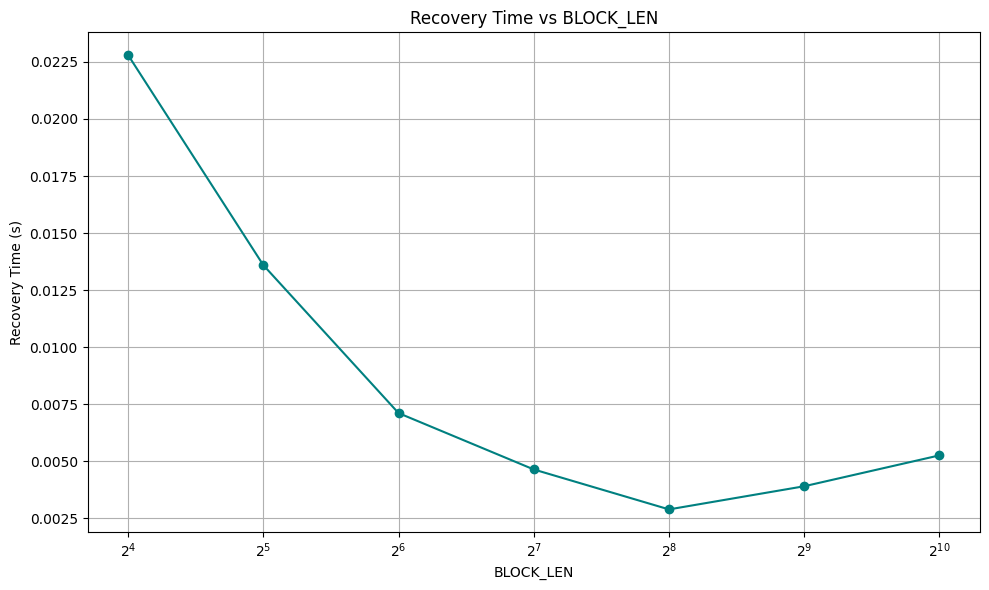

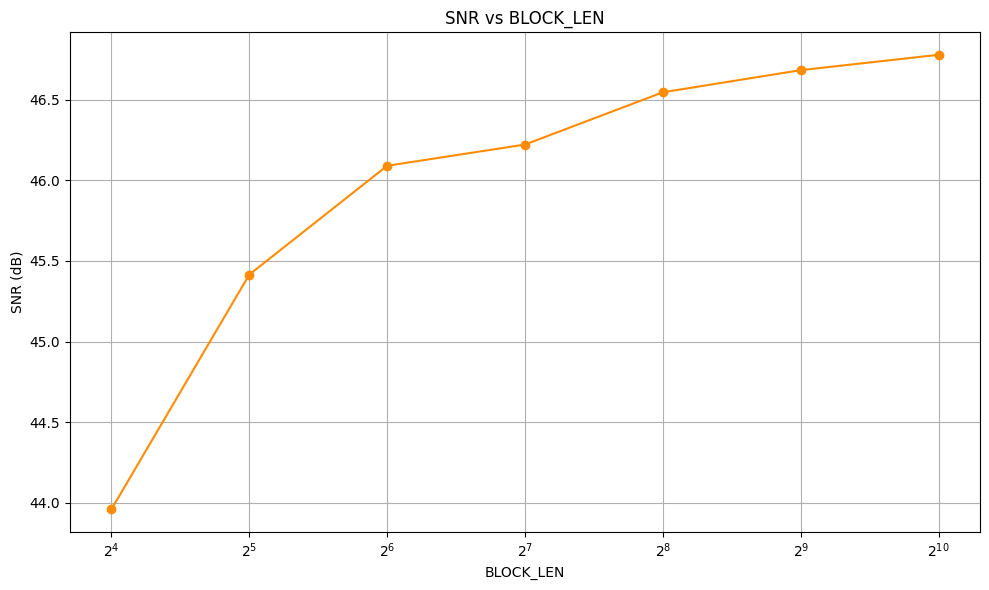

Results saved to 'outputs/block_len_vs_time_snr.csv', and plots saved to 'outputs/recovery_time_vs_block_len.png' and 'outputs/snr_vs_block_len.png'


In [104]:
import time
import scipy.io
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

if True:
    
    # Define powers of 2 for BLOCK_LEN from 16 up to 1024
    block_lens = [2**i for i in range(4, 11)]  

    # Set compression ratio (CR)
    CR = 4

    # SL0 algorithm parameters (kept fixed)
    sl0_params = {
        'sigma_min': 1e-3,
        'sigma_decrease_factor': 0.5,
        'mu_0': 2,
        'L': 3,
        'showProgress': False
    }

    # Initialize results list for storing BLOCK_LEN, execution time, and SNR
    results_list = []

    # Load the data
    data0 = scipy.io.loadmat('100m.mat')
    signal = data0['val'][0]  # MLII ECG data
    signal =  signal[:]  # Define portion of signal for testing

    # Loop through different BLOCK_LEN values
    for block_len in block_lens:
        print(f"Testing with BLOCK_LEN = {block_len}")

        # Instantiate the compressedSensing class
        cs = compressedSensing(signal=signal, BLOCK_LEN=block_len, CR=CR, matrix_type='DBBD')

        # Divide the signal into training and testing
        cs.divide_signal(training_percentage=0.9)

        # start time
        start_time = time.time()
        
        # Compress the test set
        cs.compress_test_set()

        # Calculate the elapsed time
        elapsed_time = time.time() - start_time

        # Generate the DCT-based dictionary
        cs.generate_dictionary(dictionary_type='dct')

        # Recover the signal using SL0
        cs.recover_signal(sl0_params=sl0_params)

        # Get the SNR of the reconstructed signal
        snr = cs.get_snr()

        # Append the results (BLOCK_LEN, elapsed_time, SNR) to the list
        results_list.append({
            'BLOCK_LEN': block_len,
            'Elapsed Time (s)': elapsed_time,
            'SNR (dB)': snr
        })

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Ensure the output folder exists
    output_folder = Path('outputs')
    output_folder.mkdir(parents=True, exist_ok=True)

    # Save the results to a CSV file
    csv_output_file = output_folder / 'block_len_vs_time_snr.csv'
    results_df.to_csv(csv_output_file, index=False)

    # Plot recovery time as a function of BLOCK_LEN
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['BLOCK_LEN'], results_df['Elapsed Time (s)'], marker='o', linestyle='-', color='teal')
    plt.xlabel('BLOCK_LEN')
    plt.ylabel('Recovery Time (s)')
    plt.title('Recovery Time vs BLOCK_LEN')
    plt.grid(True)
    plt.xticks(results_df['BLOCK_LEN'])
    plt.xscale('log', base=2)  # Set x-axis to log scale for powers of 2
    plt.tight_layout()

    # Save the time plot
    time_plot_file = output_folder / 'recovery_time_vs_block_len.png'
    plt.savefig(time_plot_file)
    plt.show()

    # Plot SNR as a function of BLOCK_LEN
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['BLOCK_LEN'], results_df['SNR (dB)'], marker='o', linestyle='-', color='darkorange')
    plt.xlabel('BLOCK_LEN')
    plt.ylabel('SNR (dB)')
    plt.title('SNR vs BLOCK_LEN')
    plt.grid(True)
    plt.xticks(results_df['BLOCK_LEN'])
    plt.xscale('log', base=2)  # Set x-axis to log scale for powers of 2
    plt.tight_layout()

    # Save the SNR plot
    snr_plot_file = output_folder / 'snr_vs_block_len.png'
    plt.savefig(snr_plot_file)
    plt.show()

    print(f"Results saved to '{csv_output_file}', and plots saved to '{time_plot_file}' and '{snr_plot_file}'")